# Fig 5i

In [7]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm

	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

plt.rcParams['xtick.major.size'] = 1.2  # length of major xticks
plt.rcParams['xtick.major.width'] = 0.5   # width of major xticks
plt.rcParams['ytick.major.size'] = 1.2  # length of major yticks
plt.rcParams['ytick.major.width'] = 0.5   # width of major yticks


# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
from matplotlib.colors import LogNorm

import metapredict as meta


In [37]:
from finches import Mpipi_frontend
from finches  import CALVADOS_frontend
from finches.utils import folded_domain_utils
from finches.frontend import interlogo


mf = Mpipi_frontend()
cf = CALVADOS_frontend()

/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [4]:
# read in the Gal11 ADBD PDB structure
FD = folded_domain_utils.FoldeDomain('ABD_frame0_renumbered.pdb')

In [6]:
print(f'ADBD1 sequences is: {FD.sequence}')

ADBD1 sequences is: QRRQLTPQQQQLVNQMKVAPIPKQLLQRIPNIPPNINTWQQVTALAQQKLLTPQDMEAAKEVYKIHQQLLFKARLQQQQAQ


# Show GCN4 IDR
Note we don't actually include this in the paper but below we show the GCN4 IDR definition used 

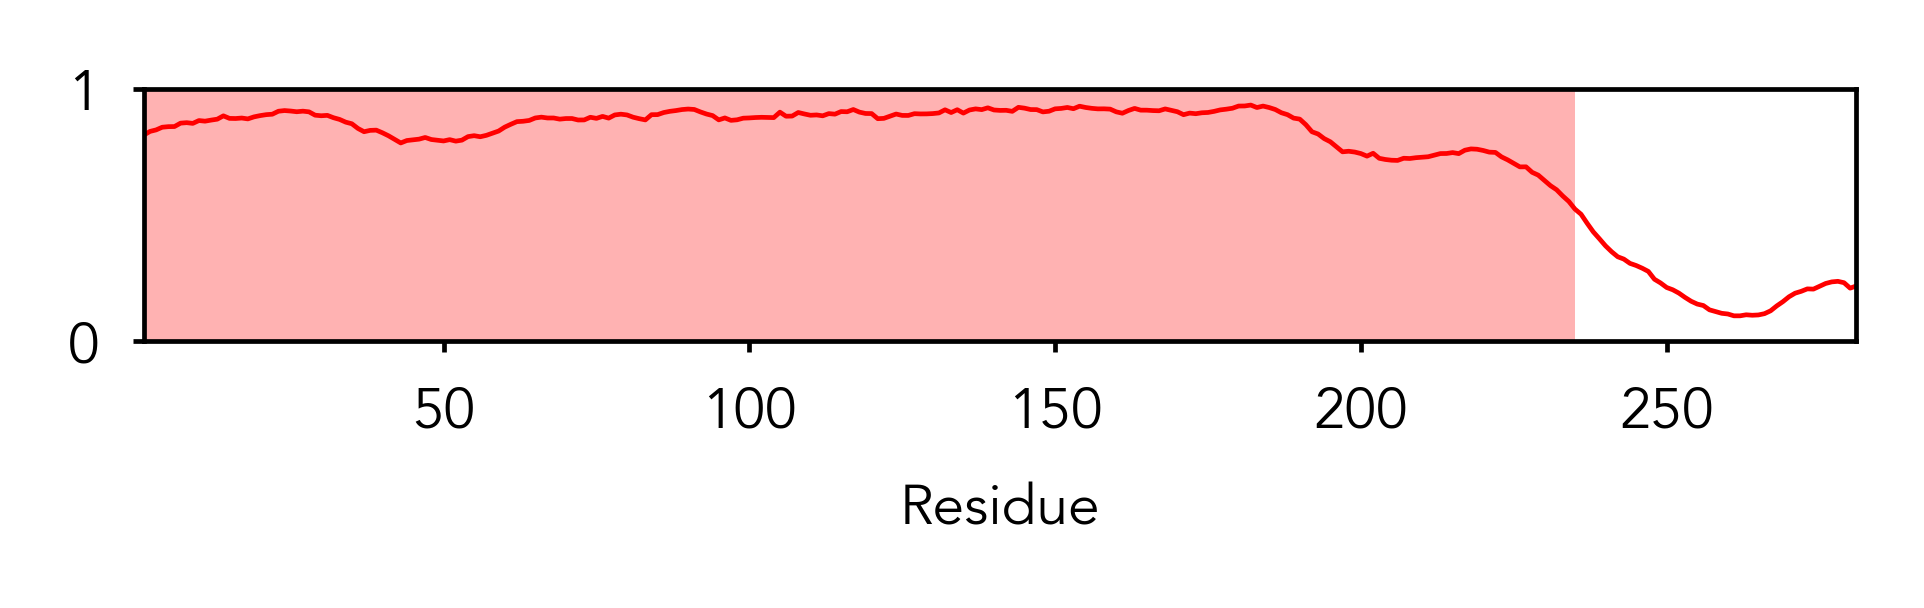

In [34]:
# GCN4 NTD

gcn4_full_length = 'MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFDKFIKTEEDPIIKQDTPSNLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGER'
gcn4_ntd         = 'MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFDKFIKTEEDPIIKQDTPSNLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNT'

figure(None, (3,1),dpi=340)
ax=plt.gca()
indices = np.arange(1,len(gcn4_full_length)+1)
plt.plot(indices, meta.predict_disorder(gcn4_full_length),'r', lw=0.5)
d = meta.predict(gcn4_full_length,return_domains=True)
ax.axvspan(d.disordered_domain_boundaries[0][0],d.disordered_domain_boundaries[0][1], alpha=0.3, color='r',lw=0)
plt.xlim([indices[0],indices[-1]]) 
plt.ylim([0,1])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Disorder', fontsize=6)
plt.xlabel('Residue', fontsize=6)
plt.tight_layout()

In [35]:
window_size = 31
X = FD.calculate_idr_surface_patch_interactions(gcn4_ntd, mf.IMC_object, window_size)

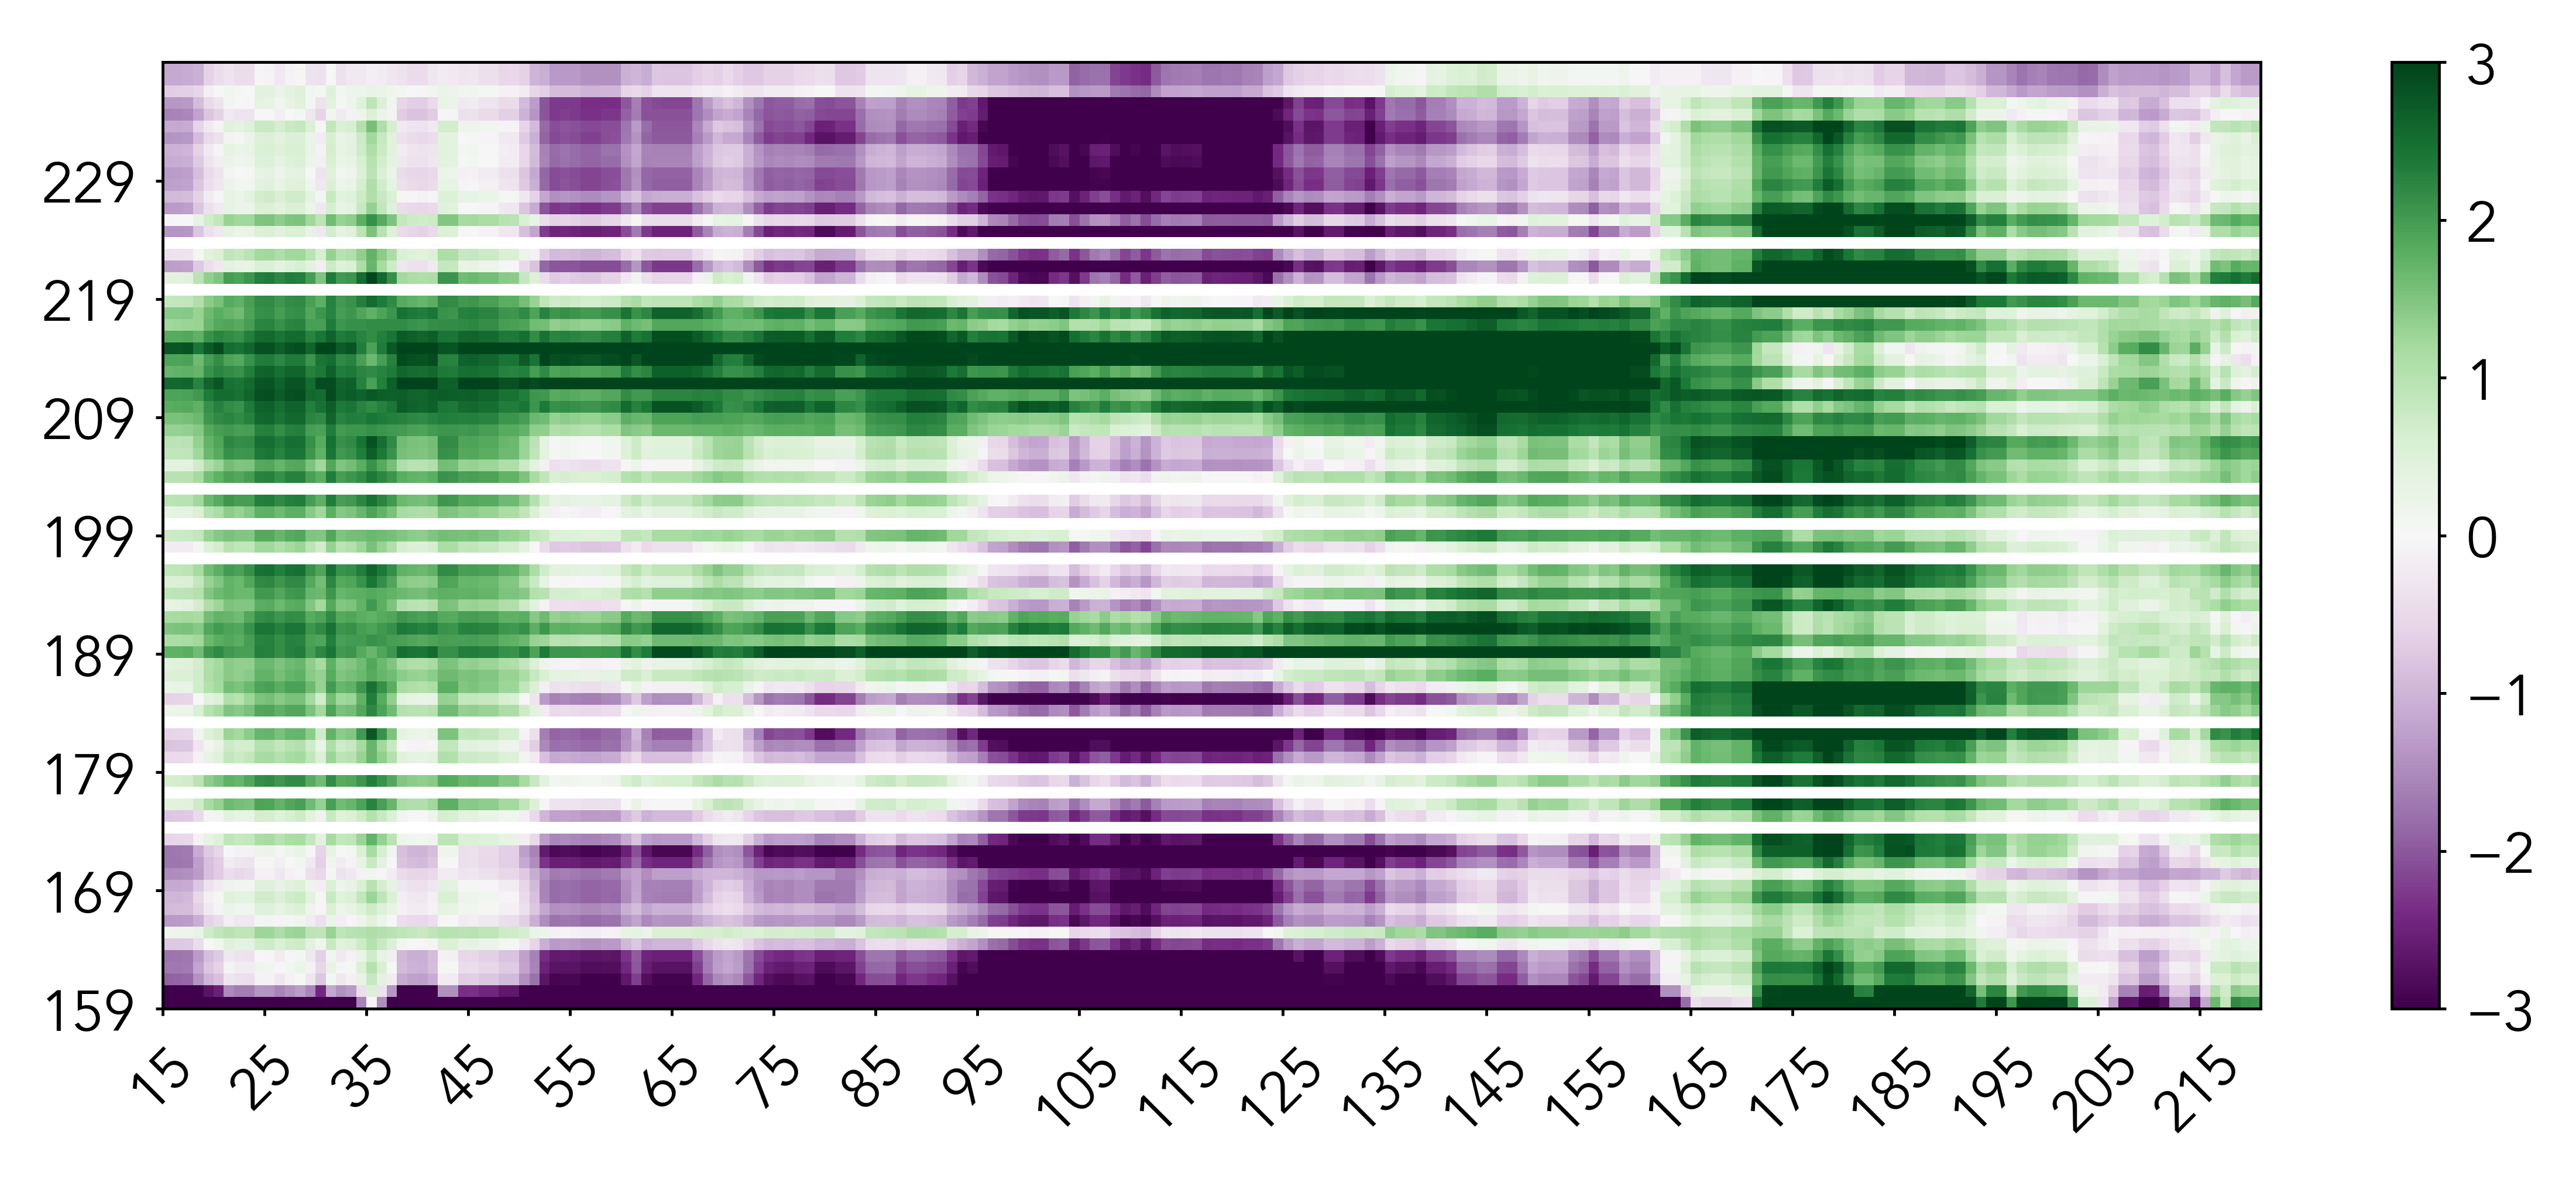

In [36]:
vmax=3
vmin=-3
cmap='PRGn'
half_window = int((window_size-1)/2)
idr_start = half_window
idr_end = len(gcn4_ntd) - half_window
fd_start = 1
fd_end = 81

figure(None, (7,3), dpi=350)


plt.imshow(X[1], extent=[idr_start, idr_end, fd_start, fd_end], origin='lower', aspect='auto', vmax=vmax, vmin=vmin, cmap=cmap)
ax=plt.gca()


tic_frequency=10

fd_start = 1
fd_end = 81


ax.set_yticks(np.arange(fd_start, fd_end, tic_frequency), np.arange(fd_start+158, fd_end+158, tic_frequency))
ax.set_xticks(np.arange(idr_start, idr_end, tic_frequency))
ax.tick_params(axis='x', rotation=45)  # Rotates the x-tick labels by 45 degrees


plt.colorbar()
plt.tight_layout()
plt.savefig('out_figures/gcn4_adbd_map.pdf')


## Fig. S15C

In [43]:
# X[2] comes from the calculate_idr_surface_patch_interactions() function, and corresponds to the mean attractive interaction
# along each IDR residue with the surface residues. The line below calculates a normalized version of this we can feed into 
# the InterLogo generation code.
norm_attractive = abs(X[2] - np.max(X[2]))

In [48]:
print(f"Length of the normalized attractive vector: {len(norm_attractive)}")
print(f"Length of the GCN4 NTD: {len(gcn4_ntd)}")

# define the amino acids based on the fact the attractive vector starts and ends at half the
# window size away from the N/C termini of the sequence
seq_start = half_window
seq_end=int(len(gcn4_ntd)-half_window)
trimmed_seq = gcn4_ntd[seq_start:seq_end]
print(f"Length of the trimmed GCN4 NTD for InterLogo: {len(trimmed_seq)}")


Length of the normalized attractive vector: 206
Length of the GCN4 NTD: 236
Length of the trimmed GCN4 NTD for InterLogo: 206


In [49]:
# quantile thresh - what quantile above which do we color?
# remainder of the parameters are fairly self explanatory...
interlogo.chemical_context_seq_plot(trimmed_seq, 
                                    norm_attractive, 
                                    max_font_sz=40, 
                                    min_font_sz=3, 
                                    quantile_threshold=0.75)
